In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, imageio, sys

sys.path.append('../src')
from models import ModelConstructor
sys.path.append('../..')
from imageNet.src.utils import normalize, calc_color_index, calc_fft_index

# figure settings
DPI=600
plt.rcParams.update({'font.family': 'Arial'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'axes.labelsize': 24})
plt.rcParams.update({'xtick.labelsize': 20})
plt.rcParams.update({'ytick.labelsize': 20})
plt.rcParams.update({'axes.titlesize': 24})
plt.rcParams.update({'axes.titleweight': 'bold'})

# standard (red) and biomimetic (blue) color
colors = np.array([[168, 14, 53], [0, 82, 137], [0, 128, 128], [128, 0, 128], [255, 165, 0]])
colors = colors/255

# constants
IMG_SIZE = (256, 256, 3)
NUM_CLASSES = 1000

#Path Settings
PROJECT_PATH = ".."
MODEL_PATH = os.path.join(PROJECT_PATH, "trained_models", "v1")
FIGURE_PATH = os.path.join(PROJECT_PATH, "figures")
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)

/opt/anaconda3/envs/tf241/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
model_name = "alexnet_3d"
train_version = 0
num_repeats = 5
model_path = os.path.join(MODEL_PATH, model_name, str(train_version))
figure_path = os.path.join(FIGURE_PATH, model_name, str(train_version))
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

list_models = ["c0-60_c0-60_c0-60_c0-60",
               "g4-60_g4-60_c0-60_c0-60"]

list_labels = ["CH240", "GL120CH120"]

model = ModelConstructor(model_name, (48, 128, 128, 3), 600)
model = model.getModel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 128, 128, 3)] 0         
_________________________________________________________________
rescaling (Rescaling)        (None, 48, 128, 128, 3)   0         
_________________________________________________________________
random_crop_and_flip (Random (None, 32, 112, 112, 3)   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 28, 23, 23, 48)    348528    
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 23, 23, 48)    192       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 13, 11, 11, 48)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 13, 11, 11, 256)   153625

In [3]:
# Check if the weight files exist
for i in range(num_repeats):
    for m in list_models:
        m = os.path.join(model_path, str(i), m+".index")
        if not os.path.exists(m):
            print("Model {} does not exist.".format(m))
            exit()

# Filter Visualization

### Normalize filters

In [4]:
w0 = model.layers[3].get_weights()[0]
num_rf = w0.shape[4]
num_tf = w0.shape[0]

normalized_filters_all = []
for repeat in range(num_repeats):
    normalized_filters = {}
    for m, n in zip(list_models, list_labels):
        # Load Model
        m = os.path.join(model_path, str(repeat), m)
        model.load_weights(m)
        w0 = model.layers[3].get_weights()[0]

        # Normalize filters
        w0_norm = np.zeros(w0.shape)
        for i in range(num_rf):
            w0_norm[:,:,:,:,i] = normalize(w0[:,:,:,:,i])
        normalized_filters[n] = w0_norm
    normalized_filters_all.append(normalized_filters)

### Calculate metrics

In [5]:
n_top_col_pixel = 48
n_times = 100
angle_interval = 1

color_index = np.zeros((num_repeats, len(list_labels), num_rf, num_tf))
freq_index = np.zeros((num_repeats, len(list_labels), num_rf, num_tf))
time_index = np.zeros((num_repeats, len(list_labels), num_rf))

for repeat in range(num_repeats):
    for k, n in enumerate(list_labels):
        flattend = np.reshape(normalized_filters_all[repeat][n], (num_tf, 22*22*3, num_rf))
        for i in range(num_rf):
            for j in range(num_tf):
                color_index[repeat, k, i, j] = calc_color_index(normalized_filters_all[repeat][n][j, :, :, :, i], n_top_col_pixel)
                freq_index[repeat, k, i, j], _ = calc_fft_index(normalized_filters_all[repeat][n][j, :, :, :, i], n_times, angle_interval)

            c = np.corrcoef(flattend[:, :, i])
            time_index[repeat, k, i] = np.min(c)

color_index_mean = np.mean(color_index, axis=-1)
freq_index_mean = np.mean(freq_index, axis=-1)

index_list = [color_index_mean, freq_index_mean, time_index]
index_name_list = ["color", "freq", "time"]

### Create GIFs

In [6]:
grid_size = 8
num_rows = np.ceil(num_rf/grid_size).astype(int)

gif_path = os.path.join(figure_path, "gifs")
frames_path = os.path.join(gif_path, "frames")
if not os.path.exists(frames_path):
    os.makedirs(frames_path)

for repeat in range(num_repeats):
    for index, index_name in zip(index_list, index_name_list):
        for k, n in enumerate(list_labels):
            order = np.argsort(index[repeat, k, :]) # Sort the filters by the index
            # Create GIF
            frames = []  # List to store frames for the GIF
            for t in range(num_tf):  # Time dimension
                fig, axs = plt.subplots(num_rows, grid_size, figsize=(grid_size, num_rows))
                for i, j in enumerate(order):
                    row = i // grid_size
                    col = i % grid_size
                    axs[row, col].imshow(np.squeeze(normalized_filters_all[repeat][n][t, :, :, :, j]), aspect='auto')
                    axs[row, col].set_xticks([])
                    axs[row, col].set_yticks([])
                # Save frame
                frame_filename = os.path.join(frames_path, f"{n}_frame_time_{t}_{index_name}_{repeat}.png")
                plt.savefig(frame_filename, bbox_inches='tight')
                plt.close()  # Close the plot to free memory
                frames.append(imageio.imread(frame_filename))

            # Create and save the GIF
            gif_filename = os.path.join(gif_path, f"{n}_filters_animation_{index_name}_{repeat}.gif")
            imageio.mimsave(gif_filename, frames, format='GIF', duration=0.5)

# Delete all the files in the frames_path
for file in os.listdir(frames_path):
    os.remove(os.path.join(frames_path, file))
os.rmdir(frames_path)

/var/folders/1f/fs1jjzfn1_z6_bgsj51sv4qr0000gn/T/ipykernel_97260/2596385556.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_filename))


### Create images

In [7]:
for repeat in range(num_repeats):
    index = time_index
    index_name = "time"
    for k, n in enumerate(list_labels):
        order = np.argsort(index[repeat, k, :])
        # Show filters
        fig, axs = plt.subplots(num_rf, num_tf, figsize=(num_tf, num_rf))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce spacing between subplots
        for i, j in enumerate(order):
            for t in range(num_tf):
                axs[i, t].imshow(np.squeeze(normalized_filters_all[repeat][n][t, :, :, :, j]))
                axs[i, t].set_xticks([])
                axs[i, t].set_yticks([])
        fig.savefig(os.path.join(figure_path, f"{n}_filters_{index_name}_{repeat}.png"), dpi=DPI, bbox_inches='tight')
        plt.close()

# Plot stats

### Histogram

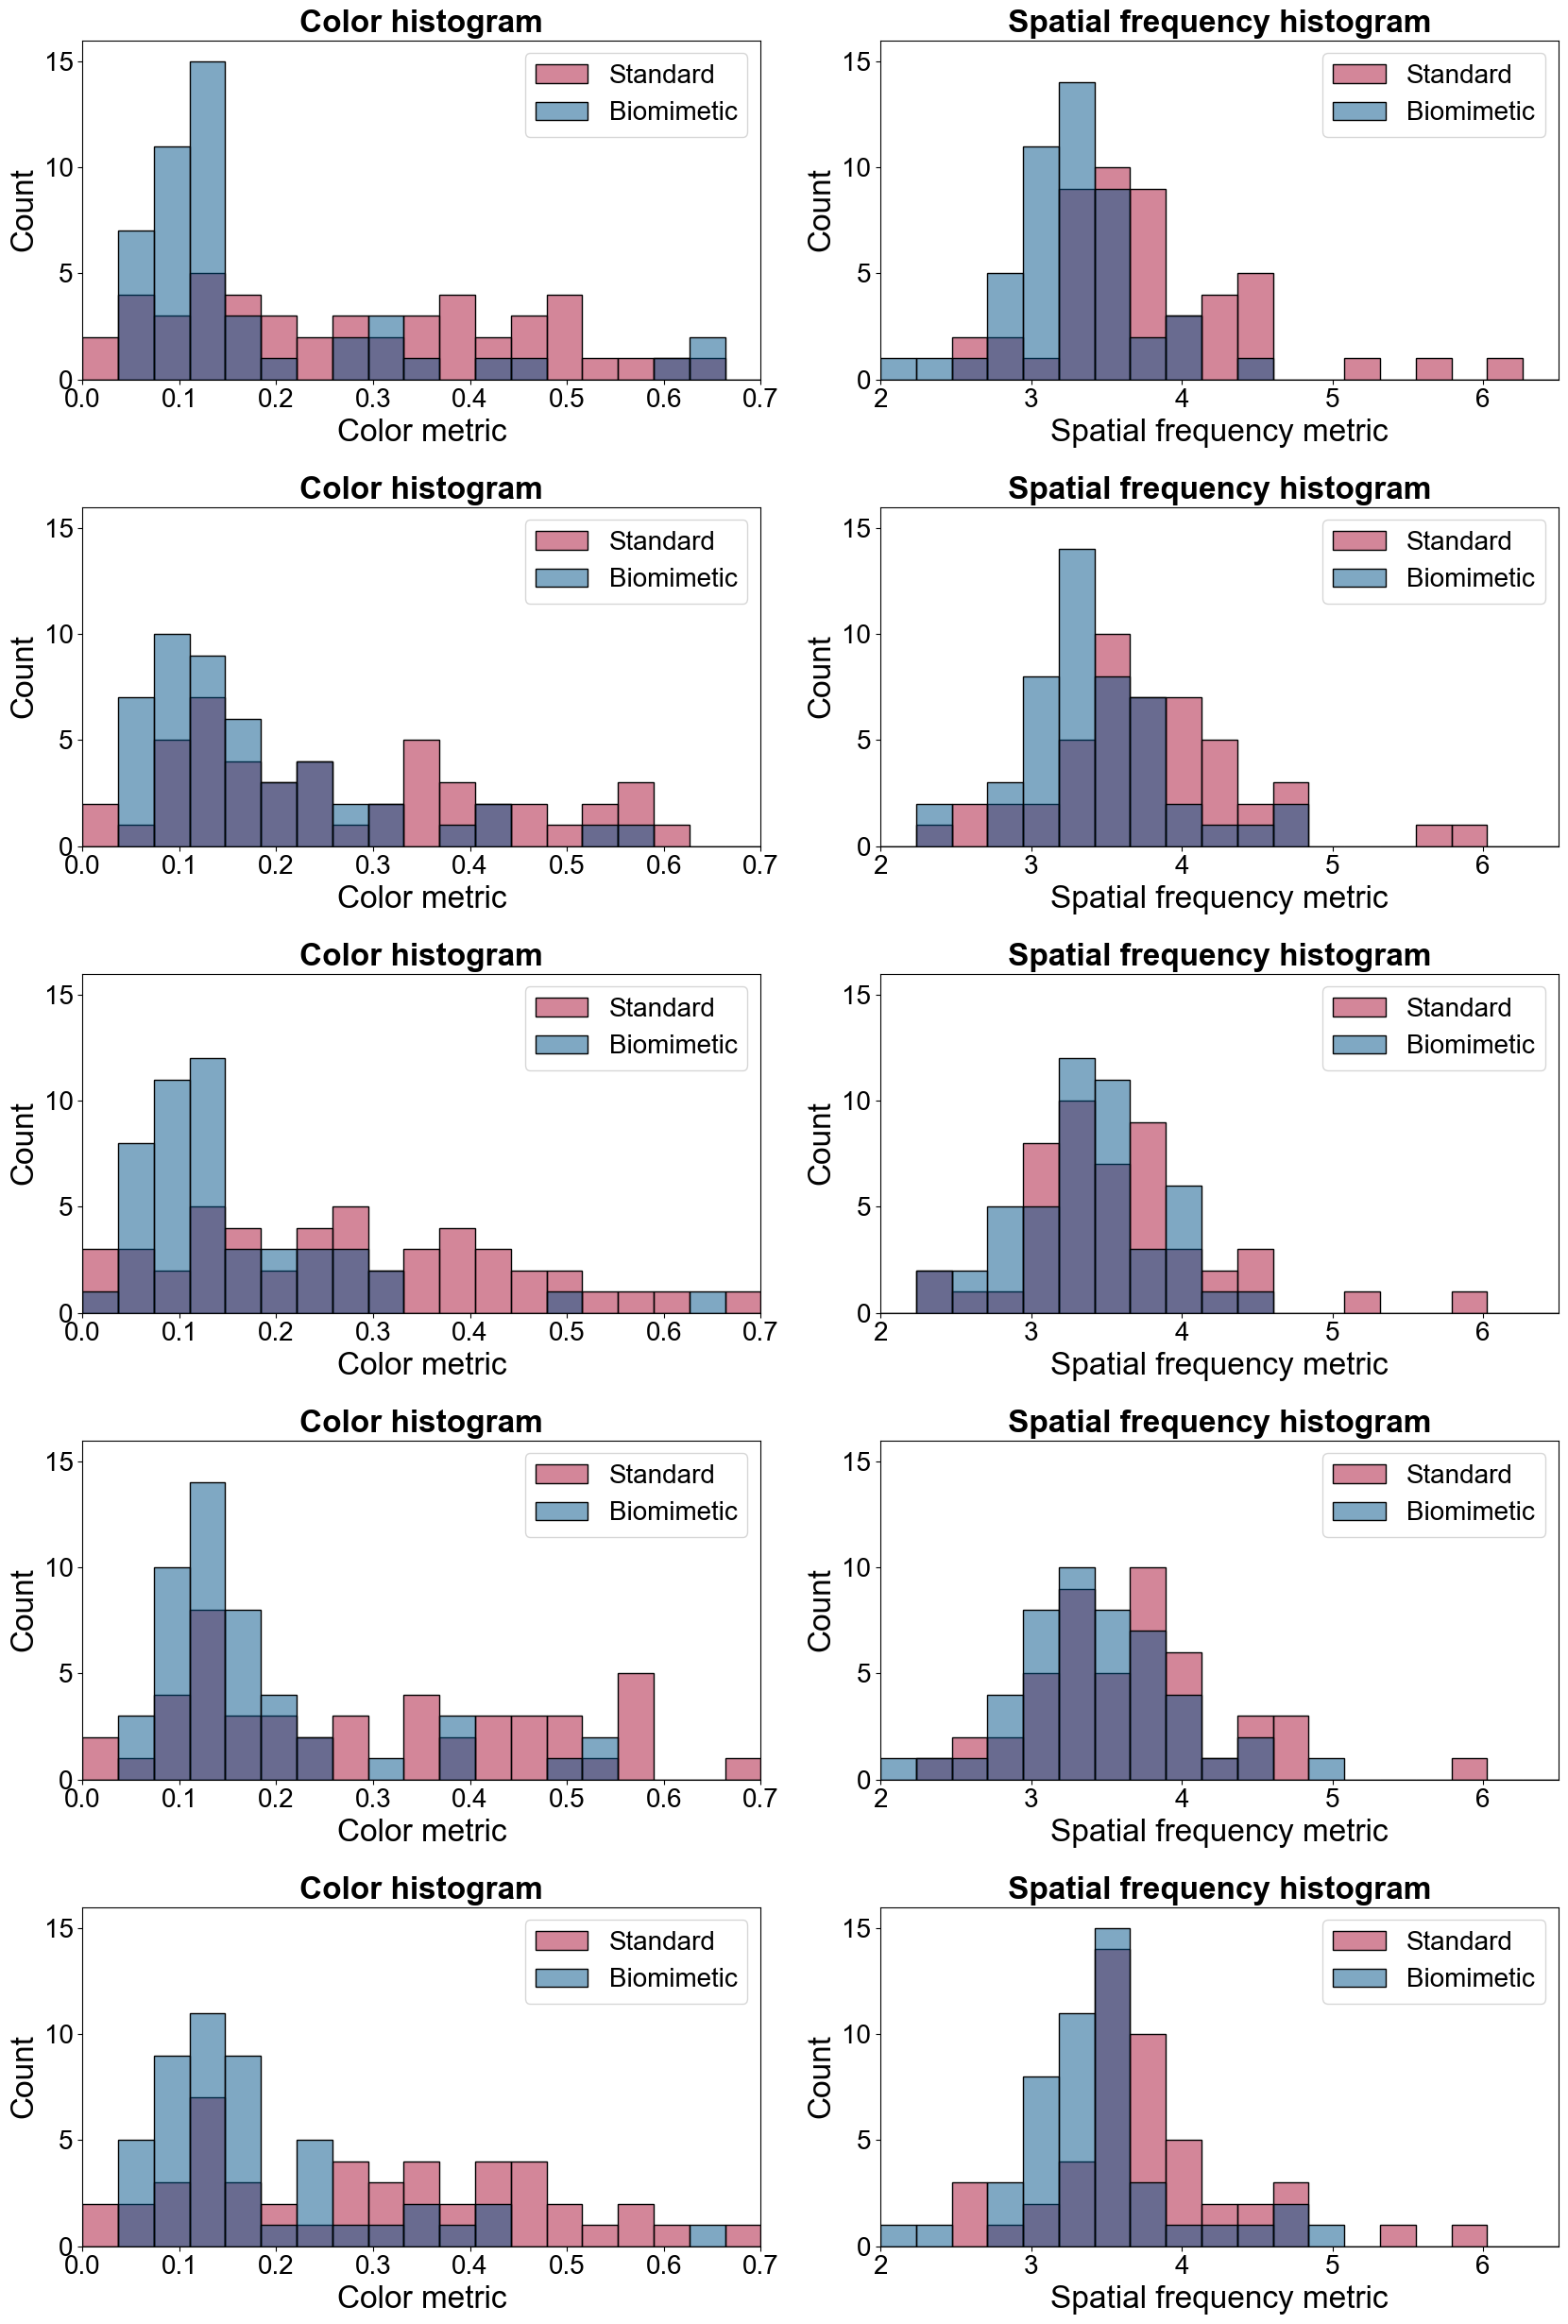

In [8]:
fig, ax = plt.subplots(num_repeats, 2, figsize=(17, 5*num_repeats))
for repeat in range(num_repeats):
    # Color metric histogram
    sns.histplot(x=color_index_mean[repeat, 0, :], bins=np.linspace(0, 0.7, 20), alpha=0.5, color=colors[0], ax=ax[repeat, 0], label='Standard')
    sns.histplot(x=color_index_mean[repeat, 1, :], bins=np.linspace(0, 0.7, 20), alpha=0.5, color=colors[1], ax=ax[repeat, 0], label='Biomimetic')
    ax[repeat, 0].set_xlim([0, 0.7])
    ax[repeat, 0].set_ylim([0, 16])
    ax[repeat, 0].set_yticks([0, 5, 10, 15])
    ax[repeat, 0].set_xlabel("Color metric")
    ax[repeat, 0].set_ylabel("Count")
    ax[repeat, 0].set_title("Color histogram")
    ax[repeat, 0].legend()
    # Spatial frequency histogram
    sns.histplot(x=freq_index_mean[repeat, 0, :], bins=np.linspace(2, 6.5, 20), alpha=0.5, color=colors[0], ax=ax[repeat, 1], label='Standard')
    sns.histplot(x=freq_index_mean[repeat, 1, :], bins=np.linspace(2, 6.5, 20), alpha=0.5, color=colors[1], ax=ax[repeat, 1], label='Biomimetic')
    ax[repeat, 1].set_xlim([2, 6.5])
    ax[repeat, 1].set_ylim([0, 16])
    ax[repeat, 1].set_yticks([0, 5, 10, 15])
    ax[repeat, 1].set_xlabel("Spatial frequency metric")
    ax[repeat, 1].set_ylabel("Count")
    ax[repeat, 1].set_title("Spatial frequency histogram")
    ax[repeat, 1].legend()
fig.tight_layout()
fig.savefig(os.path.join(figure_path, "histogram_5repeats.png"), dpi=DPI)

### Scatter

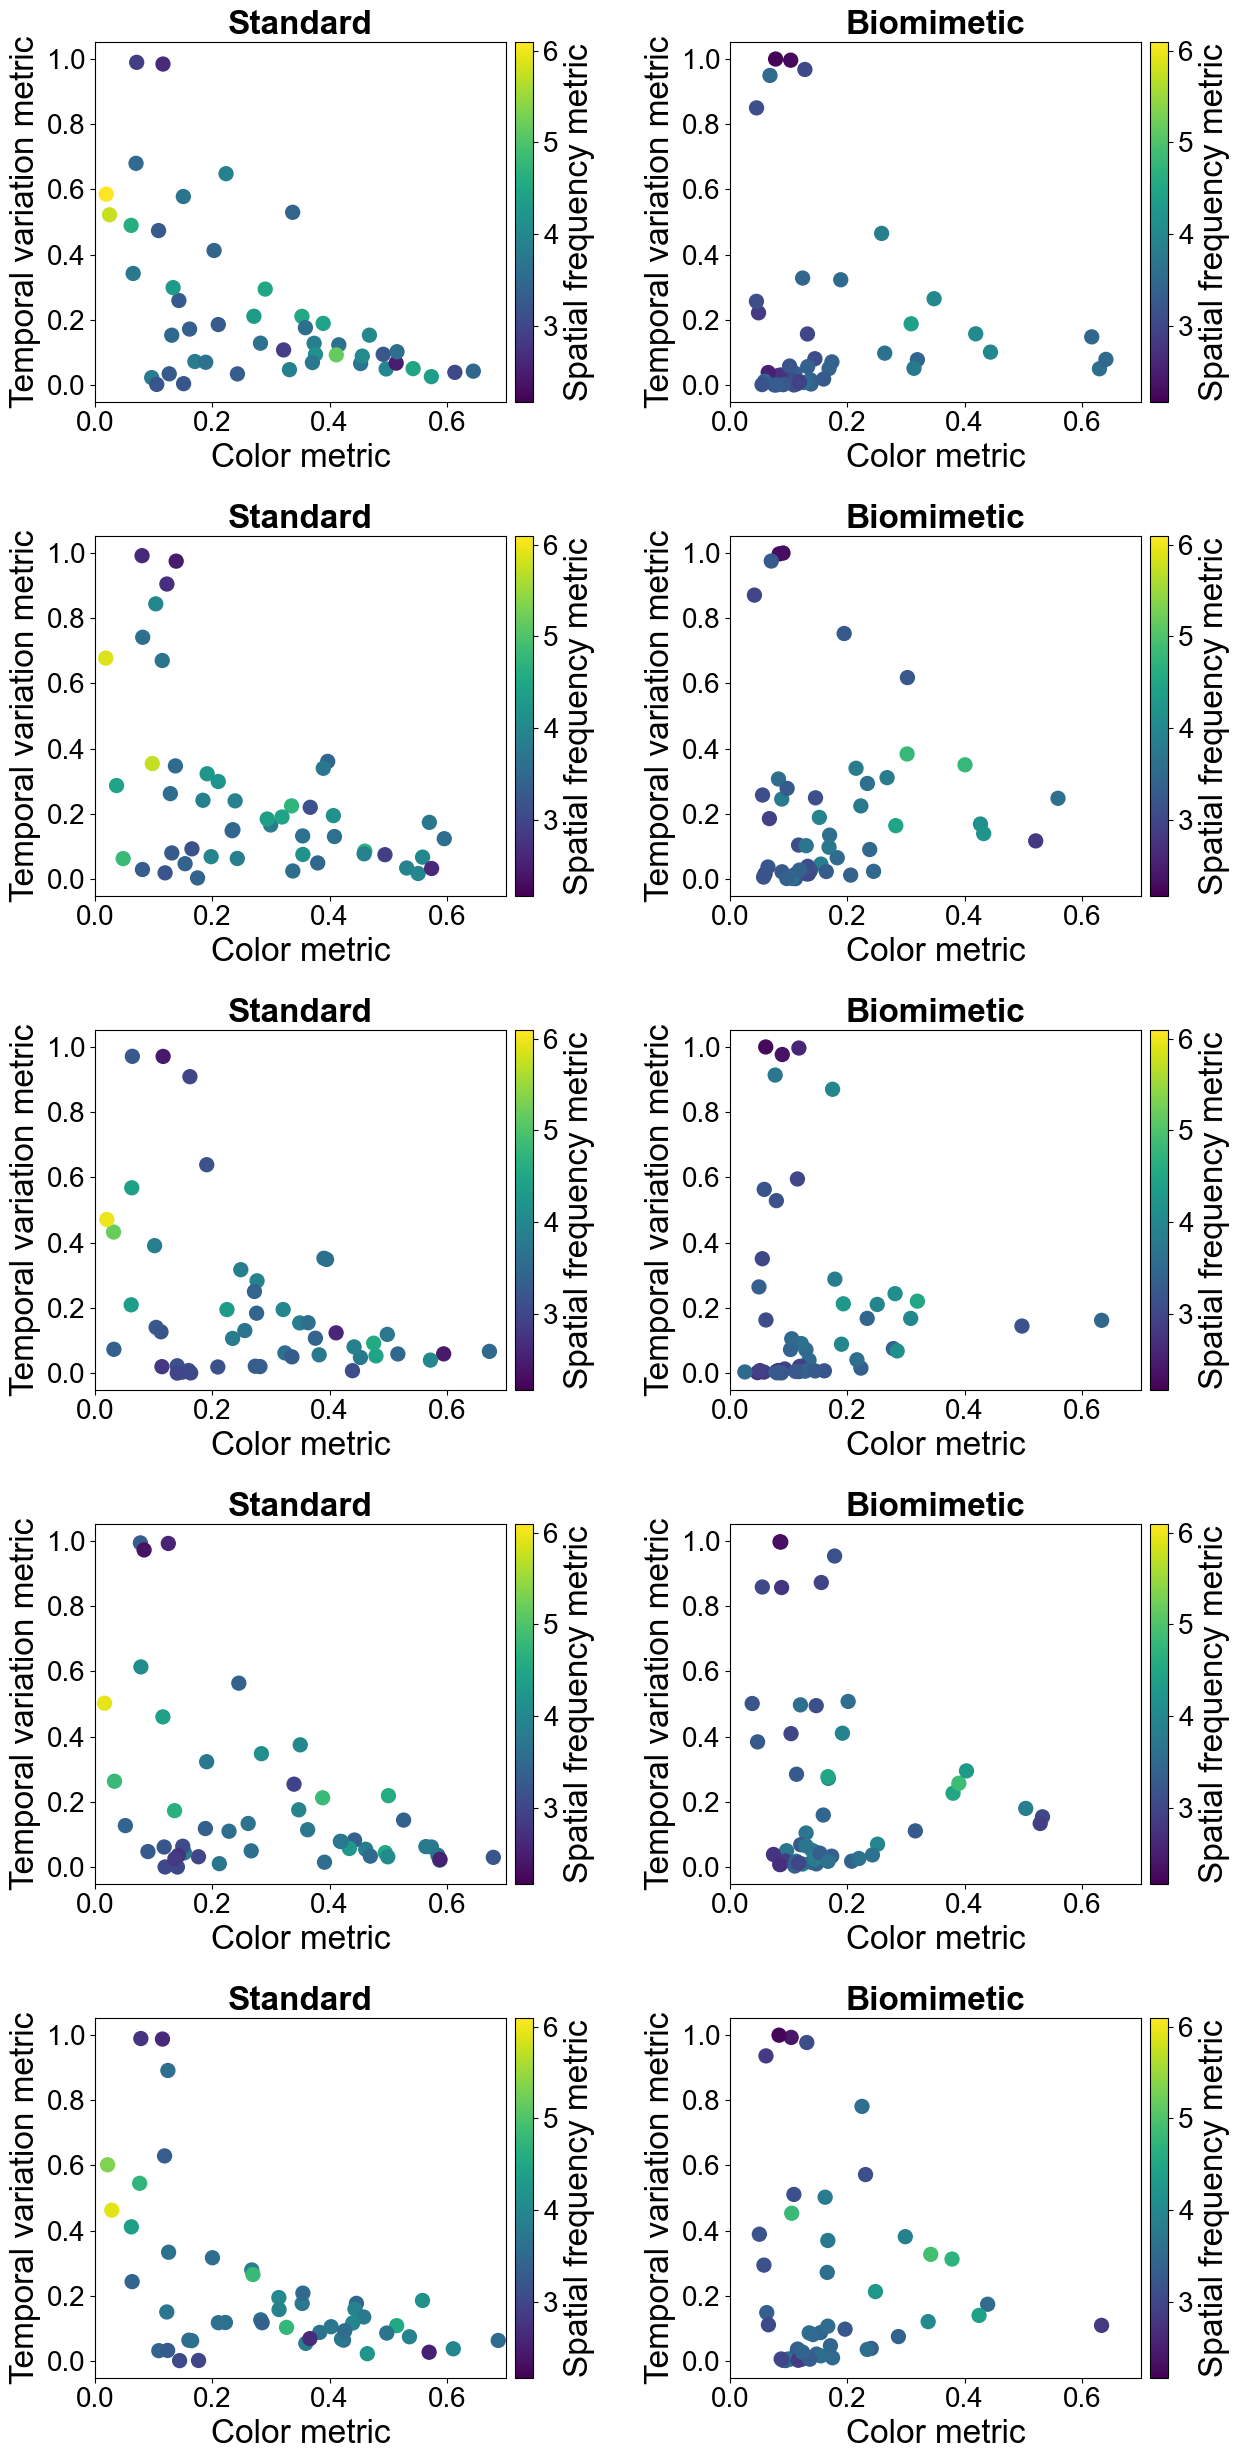

In [9]:
titles = ["Standard", "Biomimetic"]
fig, ax = plt.subplots(num_repeats, 2, figsize=(13, 5*num_repeats))
for repeat in range(num_repeats):
    for k, n in enumerate(list_labels):
        s = ax[repeat, k].scatter(color_index_mean[repeat, k, :], (1 - time_index[repeat, k, :])/2, label=list_labels[k], 
                        c=freq_index_mean[repeat, k, :], vmin=2.17, vmax=6.09, s=100)
        plt.colorbar(s, ax=ax[repeat, k], label='Spatial frequency metric', pad=0.02)
        ax[repeat, k].set_xlim([0, 0.7])
        ax[repeat, k].set_ylim([-0.05, 1.05])
        ax[repeat, k].set_xlabel("Color metric")
        ax[repeat, k].set_ylabel("Temporal variation metric")

        ax[repeat, k].set_title(f"{titles[k]}")

fig.tight_layout() 
fig.savefig(os.path.join(figure_path, "scatter_5repeats.png"), dpi=DPI)